## Demo notebook for accessing TartanAir data on Azure

<p style="color:red"> <b> !! NOTE: This sample file should only be used on Azure. To download the data to your local machine, please refer to the download instructions <a href=https://github.com/castacks/tartanair_tools#download-data>here</a> or the <a href=http://theairlab.org/tartanair-dataset>dataset website</a> for the sample data. </b> </p>

This notebook provides an example of accessing TartanAir data from blobl storage on Azure, including: 

1) navigate the directories of different environments and trajectories. 

2) load the data into memory, and 

3) visualize the data. 

## Data directory structure
```
ROOT
|
--- ENV_NAME_0                             # environment folder
|       |
|       ---- Easy                          # difficulty level
|       |      |
|       |      ---- P000                   # trajectory folder
|       |      |      |
|       |      |      +--- depth_left      # 000000_left_depth.npy - 000xxx_left_depth.npy
|       |      |      +--- depth_right     # 000000_right_depth.npy - 000xxx_right_depth.npy
|       |      |      +--- flow            # 000000_000001_flow/mask.npy - 000xxx_000xxx_flow/mask.npy
|       |      |      +--- image_left      # 000000_left.png - 000xxx_left.png 
|       |      |      +--- image_right     # 000000_right.png - 000xxx_right.png 
|       |      |      +--- seg_left        # 000000_left_seg.npy - 000xxx_left_seg.npy
|       |      |      +--- seg_right       # 000000_right_seg.npy - 000xxx_right_seg.npy
|       |      |      ---- pose_left.txt 
|       |      |      ---- pose_right.txt
|       |      |  
|       |      +--- P001
|       |      .
|       |      .
|       |      |
|       |      +--- P00K
|       |
|       +--- Hard
|
+-- ENV_NAME_1
.
.
|
+-- ENV_NAME_N
 ```

## Notebook dependencies
`pip install numpy`

`pip install azure-storage-blob`

`pip install opencv-python`

## Imports and contrainer_client

In [1]:
from azure.storage.blob import ContainerClient
import numpy as np
import io
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset website: http://theairlab.org/tartanair-dataset/
account_url = 'https://tartanair.blob.core.windows.net/'
container_name = 'tartanair-release1'

container_client = ContainerClient(account_url=account_url, 
                                 container_name=container_name,
                                 credential=None)

## List the environments and trajectories

In [2]:
def get_environment_list():
    '''
    List all the environments shown in the root directory
    '''
    env_gen = container_client.walk_blobs()
    envlist = []
    for env in env_gen:
        envlist.append(env.name)
    return envlist

def get_trajectory_list(envname, easy_hard = 'Easy'):
    '''
    List all the trajectory folders, which is named as 'P0XX'
    '''
    assert(easy_hard=='Easy' or easy_hard=='Hard')
    traj_gen = container_client.walk_blobs(name_starts_with=envname + '/' + easy_hard+'/')
    trajlist = []
    for traj in traj_gen:
        trajname = traj.name
        trajname_split = trajname.split('/')
        trajname_split = [tt for tt in trajname_split if len(tt)>0]
        if trajname_split[-1][0] == 'P':
            trajlist.append(trajname)
    return trajlist

def _list_blobs_in_folder(folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files

def get_image_list(trajdir, left_right = 'left'):
    assert(left_right == 'left' or left_right == 'right')
    files = _list_blobs_in_folder(trajdir + '/image_' + left_right + '/')
    files = [fn for fn in files if fn.endswith('.png')]
    return files

def get_depth_list(trajdir, left_right = 'left'):
    assert(left_right == 'left' or left_right == 'right')
    files = _list_blobs_in_folder(trajdir + '/depth_' + left_right + '/')
    files = [fn for fn in files if fn.endswith('.npy')]
    return files

def get_flow_list(trajdir, ):
    files = _list_blobs_in_folder(trajdir + '/flow/')
    files = [fn for fn in files if fn.endswith('flow.npy')]
    return files

def get_flow_mask_list(trajdir, ):
    files = _list_blobs_in_folder(trajdir + '/flow/')
    files = [fn for fn in files if fn.endswith('mask.npy')]
    return files

def get_posefile(trajdir, left_right = 'left'):
    assert(left_right == 'left' or left_right == 'right')
    return trajdir + '/pose_' + left_right + '.txt'

def get_seg_list(trajdir, left_right = 'left'):
    assert(left_right == 'left' or left_right == 'right')
    files = _list_blobs_in_folder(trajdir + '/seg_' + left_right + '/')
    files = [fn for fn in files if fn.endswith('.npy')]
    return files

### List all the environments 

In [3]:
envlist = get_environment_list()
print('Find {} environments..'.format(len(envlist)))
print(envlist)

Find 18 environments..
['abandonedfactory/', 'abandonedfactory_night/', 'amusement/', 'carwelding/', 'endofworld/', 'gascola/', 'hospital/', 'japanesealley/', 'neighborhood/', 'ocean/', 'office/', 'office2/', 'oldtown/', 'seasidetown/', 'seasonsforest/', 'seasonsforest_winter/', 'soulcity/', 'westerndesert/']


### List all the 'Easy' trajectories in the first environment 

In [4]:
diff_level = 'Easy'
env_ind = 0
trajlist = get_trajectory_list(envlist[env_ind], easy_hard = diff_level)
print('Find {} trajectories in {}'.format(len(trajlist), envlist[env_ind]+diff_level))
print(trajlist)

Find 10 trajectories in abandonedfactory/Easy
['abandonedfactory/Easy/P000/', 'abandonedfactory/Easy/P001/', 'abandonedfactory/Easy/P002/', 'abandonedfactory/Easy/P004/', 'abandonedfactory/Easy/P005/', 'abandonedfactory/Easy/P006/', 'abandonedfactory/Easy/P008/', 'abandonedfactory/Easy/P009/', 'abandonedfactory/Easy/P010/', 'abandonedfactory/Easy/P011/']


### List all the data files in one trajectory

In [5]:
traj_ind = 1
traj_dir = trajlist[traj_ind]

left_img_list = get_image_list(traj_dir, left_right = 'left')
print('Find {} left images in {}'.format(len(left_img_list), traj_dir))  

right_img_list = get_image_list(traj_dir, left_right = 'right')
print('Find {} right images in {}'.format(len(right_img_list), traj_dir))

left_depth_list = get_depth_list(traj_dir, left_right = 'left')
print('Find {} left depth files in {}'.format(len(left_depth_list), traj_dir))

right_depth_list = get_depth_list(traj_dir, left_right = 'right')
print('Find {} right depth files in {}'.format(len(right_depth_list), traj_dir))

left_seg_list = get_seg_list(traj_dir, left_right = 'left')
print('Find {} left segmentation files in {}'.format(len(left_seg_list), traj_dir))

right_seg_list = get_seg_list(traj_dir, left_right = 'left')
print('Find {} right segmentation files in {}'.format(len(right_seg_list), traj_dir))

flow_list = get_flow_list(traj_dir)
print('Find {} flow files in {}'.format(len(flow_list), traj_dir)) 

flow_mask_list = get_flow_mask_list(traj_dir)
print('Find {} flow mask files in {}'.format(len(flow_mask_list), traj_dir)) 

left_pose_file = get_posefile(traj_dir, left_right = 'left')
print('Left pose file: {}'.format(left_pose_file))

right_pose_file = get_posefile(traj_dir, left_right = 'right')
print('Right pose file: {}'.format(right_pose_file))

Find 434 left images in abandonedfactory/Easy/P001/
Find 434 right images in abandonedfactory/Easy/P001/
Find 434 left depth files in abandonedfactory/Easy/P001/
Find 434 right depth files in abandonedfactory/Easy/P001/
Find 434 left segmentation files in abandonedfactory/Easy/P001/
Find 434 right segmentation files in abandonedfactory/Easy/P001/
Find 433 flow files in abandonedfactory/Easy/P001/
Find 433 flow mask files in abandonedfactory/Easy/P001/
Left pose file: abandonedfactory/Easy/P001//pose_left.txt
Right pose file: abandonedfactory/Easy/P001//pose_right.txt


## Functions for data downloading

In [6]:
def read_numpy_file(numpy_file,):
    '''
    return a numpy array given the file path
    '''
    bc = container_client.get_blob_client(blob=numpy_file)
    data = bc.download_blob()
    ee = io.BytesIO(data.content_as_bytes())
    ff = np.load(ee)
    return ff


def read_image_file(image_file,):
    '''
    return a uint8 numpy array given the file path  
    '''
    bc = container_client.get_blob_client(blob=image_file)
    data = bc.download_blob()
    ee = io.BytesIO(data.content_as_bytes())
    img=cv2.imdecode(np.asarray(bytearray(ee.read()),dtype=np.uint8), cv2.IMREAD_COLOR)
    im_rgb = img[:, :, [2, 1, 0]] # BGR2RGB
    return im_rgb


## Functions for data visualization

In [7]:
def depth2vis(depth, maxthresh = 50):
    depthvis = np.clip(depth,0,maxthresh)
    depthvis = depthvis/maxthresh*255
    depthvis = depthvis.astype(np.uint8)
    depthvis = np.tile(depthvis.reshape(depthvis.shape+(1,)), (1,1,3))

    return depthvis

def seg2vis(segnp):
    colors = np.loadtxt('seg_rgbs.txt')
    segvis = np.zeros(segnp.shape+(3,), dtype=np.uint8)

    for k in range(256):
        mask = segnp==k
        colorind = k % len(colors)
        if np.sum(mask)>0:
            segvis[mask,:] = colors[colorind]

    return segvis

def _calculate_angle_distance_from_du_dv(du, dv, flagDegree=False):
    a = np.arctan2( dv, du )

    angleShift = np.pi

    if ( True == flagDegree ):
        a = a / np.pi * 180
        angleShift = 180
        # print("Convert angle from radian to degree as demanded by the input file.")

    d = np.sqrt( du * du + dv * dv )

    return a, d, angleShift

def flow2vis(flownp, maxF=500.0, n=8, mask=None, hueMax=179, angShift=0.0): 
    """
    Show a optical flow field as the KITTI dataset does.
    Some parts of this function is the transform of the original MATLAB code flow_to_color.m.
    """

    ang, mag, _ = _calculate_angle_distance_from_du_dv( flownp[:, :, 0], flownp[:, :, 1], flagDegree=False )

    # Use Hue, Saturation, Value colour model 
    hsv = np.zeros( ( ang.shape[0], ang.shape[1], 3 ) , dtype=np.float32)

    am = ang < 0
    ang[am] = ang[am] + np.pi * 2

    hsv[ :, :, 0 ] = np.remainder( ( ang + angShift ) / (2*np.pi), 1 )
    hsv[ :, :, 1 ] = mag / maxF * n
    hsv[ :, :, 2 ] = (n - hsv[:, :, 1])/n

    hsv[:, :, 0] = np.clip( hsv[:, :, 0], 0, 1 ) * hueMax
    hsv[:, :, 1:3] = np.clip( hsv[:, :, 1:3], 0, 1 ) * 255
    hsv = hsv.astype(np.uint8)

    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    if ( mask is not None ):
        mask = mask > 0
        rgb[mask] = np.array([0, 0 ,0], dtype=np.uint8)

    return rgb


### Download and visualize the data

In [8]:
data_ind = 173 # randomly select one frame (data_ind < TRAJ_LEN)

#### Visualize the left and right RGB images

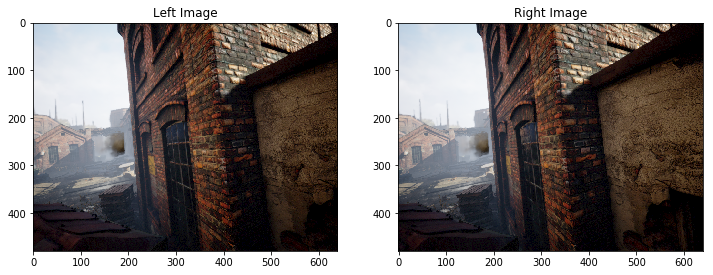

In [9]:
left_img = read_image_file(left_img_list[data_ind])
right_img = read_image_file(right_img_list[data_ind])

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(left_img)
plt.title('Left Image')
plt.subplot(122)
plt.imshow(right_img)
plt.title('Right Image')
plt.show()

#### Visualize the left and right depth files

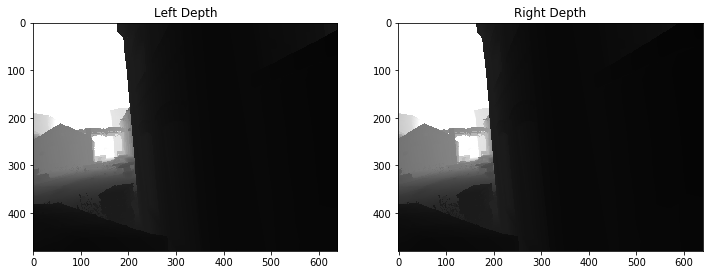

In [10]:
left_depth = read_numpy_file(left_depth_list[data_ind])
left_depth_vis = depth2vis(left_depth)

right_depth = read_numpy_file(right_depth_list[data_ind])
right_depth_vis = depth2vis(right_depth)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(left_depth_vis)
plt.title('Left Depth')
plt.subplot(122)
plt.imshow(right_depth_vis)
plt.title('Right Depth')
plt.show()

#### Visualize the left and right segmentation files

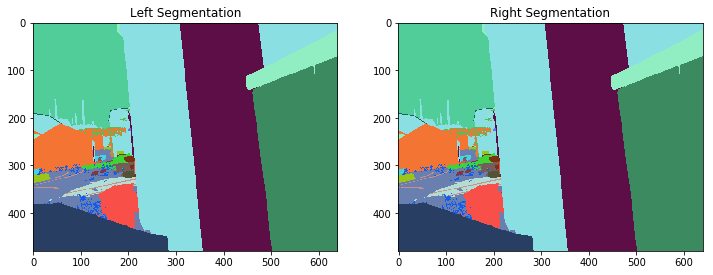

In [11]:
left_seg = read_numpy_file(left_seg_list[data_ind])
left_seg_vis = seg2vis(left_seg)

right_seg = read_numpy_file(right_seg_list[data_ind])
right_seg_vis = seg2vis(right_seg)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(left_seg_vis)
plt.title('Left Segmentation')
plt.subplot(122)
plt.imshow(right_seg_vis)
plt.title('Right Segmentation')
plt.show()

#### Visualize the flow and mask files

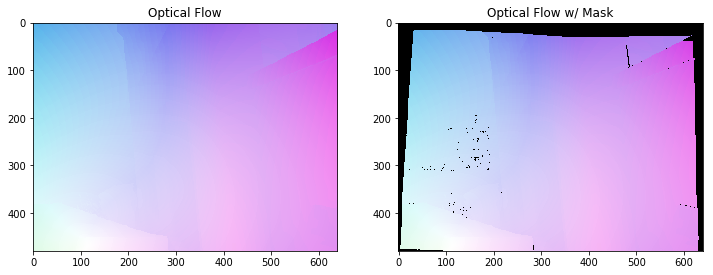

In [12]:
flow = read_numpy_file(flow_list[data_ind])
flow_vis = flow2vis(flow)

flow_mask = read_numpy_file(flow_mask_list[data_ind])
flow_vis_w_mask = flow2vis(flow, mask = flow_mask)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(flow_vis)
plt.title('Optical Flow')
plt.subplot(122)
plt.imshow(flow_vis_w_mask)
plt.title('Optical Flow w/ Mask')
plt.show()